(tensor-network-drawing)=

# Drawing

`quimb` has a lot of functionality for drawing tensor networks that can be
useful for debugging, interactive development, and producing figures etc.
This page is a general overview of various options, mostly centered around the
method [`TensorNetwork.draw`](quimb.tensor.tensor_core.TensorNetwork.draw). Underneath this
calls [networkx](https://networkx.org/documentation/stable//reference/drawing.html)
which itself uses [matplotlib](https://matplotlib.org/).

In [1]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

import quimb.tensor as qtn

We'll use a 3D grid tensor network as our basic example.

In [2]:
Lx = Ly = Lz = 4
D = 2
tn = qtn.TN3D_rand(Lx, Ly, Lz, D=D)

By default bonds are draw proportional to `log2` of their dimension, whereas nodes are fixed in size.

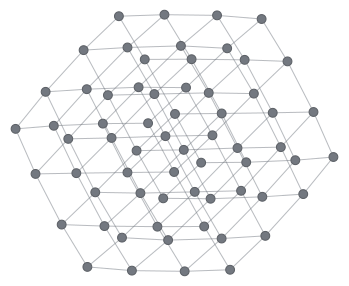

In [3]:
tn.draw()

By default index names are not shown and tensor tags are only shown for small tensors, these can both be controlled manually like so:

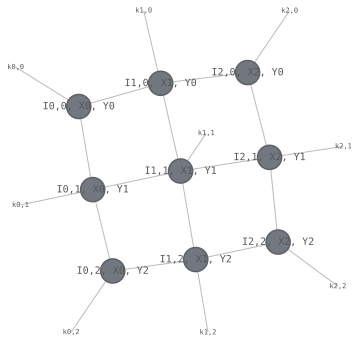

In [4]:
qtn.PEPS.rand(3, 3, D).draw(show_tags=True, show_inds=True)

If you want to see inner index names (bonds) as well as the outer index names you need to use `show_inds='all'`:

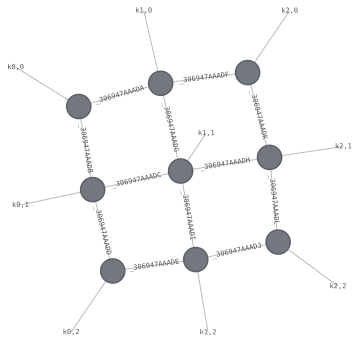

In [5]:
qtn.PEPS.rand(3, 3, D).draw(show_tags=False, show_inds="all")

## Coloring

The first argument to `draw` is `color=`, which can either be a single tag or a sequence of tags:

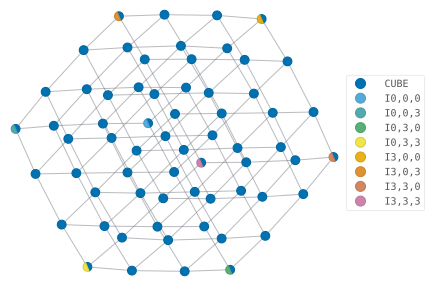

In [6]:
# add the same tag to every tensor
tn.add_tag("CUBE")

# color that tag and each corner of our TN
color = ["CUBE"] + [
    f"I{i},{j},{k}"
    for i in (0, Lx - 1)
    for j in (0, Ly - 1)
    for k in (0, Lz - 1)
]

tn.draw(color)

If you have many tags or are simply only interested in the drawing the colors you can supply the `legend=False` option to turn off the legend.
`quimb` can show tensor which have multiple matching tags - the style is controlled by the kwarg `multi_tag_style` which should be one of:
`{"auto", "pie", "nest", "average", "last"}`.

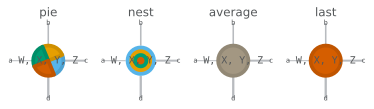

In [7]:
t = qtn.rand_tensor([2, 3, 4, 5], "abcd", ["W", "X", "Y", "Z"])

fig, axs = plt.subplots(1, 4)

for i, multi_tag_style in enumerate(["pie", "nest", "average", "last"]):
    t.draw(
        ["W", "X", "Y", "Z"],
        multi_tag_style=multi_tag_style,
        ax=axs[i],
        node_scale=2,
        title=multi_tag_style,
        legend=False,
    )

:::{hint}
`quimb` tries to produce a sequence of colors that are reasonably locally distigushable
but also have some global ordering when using many colors. These are based on the palette
designed with  color blindness in mind by [Okabe & Ito](https://jfly.uni-koeln.de/color/).
You can supply custom colors with the `custom_colors=` kwarg.
:::

## Highlighting indices

You can visualize a subset of indices by supplying a sequence of them to the `highlight_inds=` kwarg like so:

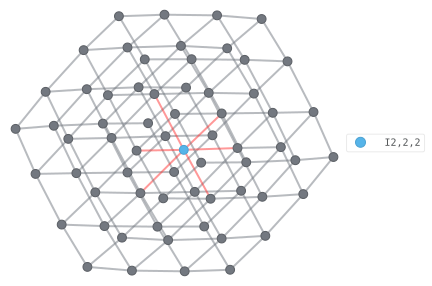

In [8]:
# get a central tensor and its indices
tag = f"I{Lx // 2},{Ly // 2},{Lz // 2}"
t = tn[tag]
inds = t.inds
tn.draw(color=tag, highlight_inds=inds, edge_scale=2)

The color can be controlled with ``highlight_inds_color``.

## Highlighting `tids`

While tensors can carry arbitrary tags and can usually be identified by these, it is sometimes useful to be able to highlight tensors based on their underlying `tids` - each of which is a unique integer representing a node in the hypergraph.

In [9]:
# get the first plane of tensor tids
tids = list(tn.tensor_map.keys())[: Lx * Ly]
tids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

The color can be controlled with `highlight_tids_color`:

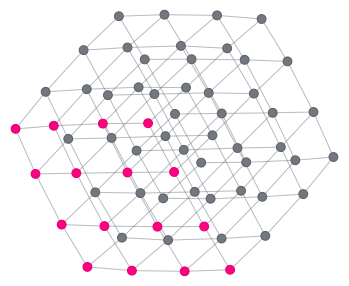

In [10]:
tn.draw(highlight_tids=tids, highlight_tids_color=(1.0, 0.0, 0.5, 0.5))

## Auto coloring edges

You can auto color the edges of a tensor network by supplying
`color_edges=True`, the colors will match the fancy HTML repr colors:

In [11]:
tn2d = qtn.TN2D_rand(3, 3, 4)
tn2d

TensorNetwork2D(tensors=9, indices=12, Lx=3, Ly=3, max_bond=4)

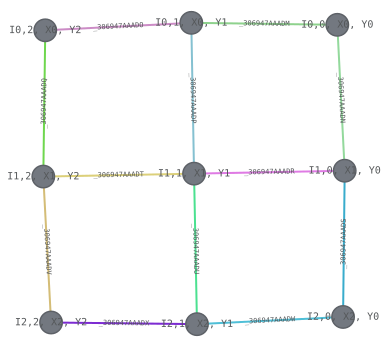

In [12]:
tn2d.draw(edge_color=True, show_inds="all")

## Specifying output indices

The output indices of a tensor network are assumed to be those that appear on a single tensor. For hyper tensor networks where this is not the case you can specify `output_inds` explicitly, to ensure that they will be rended as dangling.

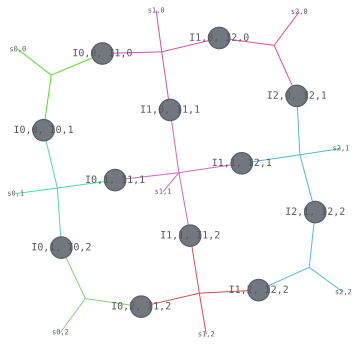

In [13]:
Lx = Ly = 3
htn = qtn.HTN2D_classical_ising_partition_function(Lx, Ly, beta=1.0)
output_inds = [f"s{i},{j}" for i in range(Lx) for j in range(Ly)]
htn.draw(output_inds=output_inds, edge_color=True)

## Positioning tensors

### Automatic layouts

The automatic layout strategy `quimb` adopts (`layout="auto"`) is to lay the tensors out using some relatively efficient scheme, before 'relaxing' the positions using a (slower) force repulsion algorithm into something usually more natural.

Relevant options are:
- `layout`: if `"auto"` use the options below, else specify a layout directly (with no relaxation, i.e. set `iterations=0`).
- `initial_layout`: if using relaxation, the starting layout (the default for which is `'kamada_kawai'` for small graphs and `'spectral'` for large graphs).
- `iterations`: controls the number of force repulsion steps.

Another decent `networxk` choice for the initial layout that you might try if `'kamada_kawai'` isn't producing good results is `'spectral'`. You should also be able to specify most of the [networkx layout algorithms](https://networkx.org/documentation/stable//reference/drawing.html#module-networkx.drawing.layout).

If you have [`pygraphviz`](https://pygraphviz.github.io/) installed then you can use the layouts `"neato"`, `"sfdp"` and `"dot"`.

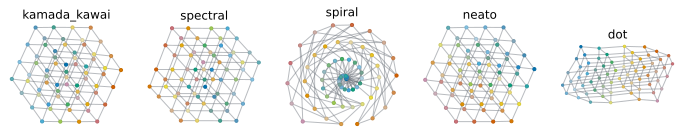

In [14]:
fig, axs = plt.subplots(ncols=5, figsize=(12, 3))

for ax, layout in zip(
    axs,
    [
        "kamada_kawai",
        "spectral",
        "spiral",
        "neato",
        "dot",
    ],
):
    tn.draw(tn.site_tags, ax=ax, layout=layout)
    ax.set_title(layout)
    ax.set_aspect("equal")
    ax.axis("off")

plt.show()
plt.close()

### Force Repulsion options

For the [force repulsion layout](https://networkx.org/documentation/stable//reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout),
you can supply the spring constant `k`, which can have a significant effect on the layout:

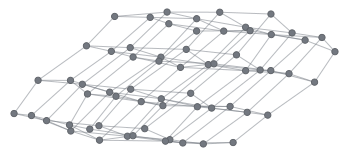

In [15]:
tn.draw(iterations=100, k=0.01)

You can also fix specific tensors (by either a `tid` or set of tags that uniquely identifies that tensor):

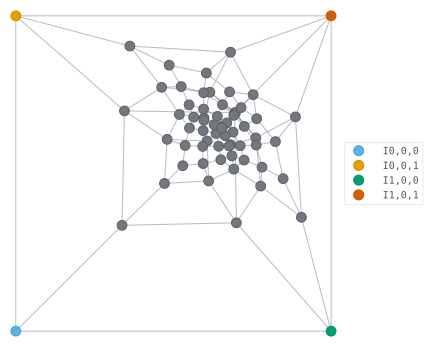

In [16]:
fix = {
    "I0,0,0": (0, 0),
    "I0,0,1": (0, 1),
    "I1,0,0": (1, 0),
    "I1,0,1": (1, 1),
}

# when fixing tensors you often have to play with ``k``
tn.draw(k=0.001, fix=fix, color=fix.keys())

If you have [`forceatlas2` (`fa2`) ](https://github.com/bhargavchippada/forceatlas2) installed then you can specify to use it rather than the slower networkx force repulsion algorithm at a certain threshold of nodes (by default 1000) with the option `use_forceatlas2=1000`.

### Manually Specifying

You can also simply specify all positions manually using the `fix` kwarg. Here's that illustrated with a axonometric projection:

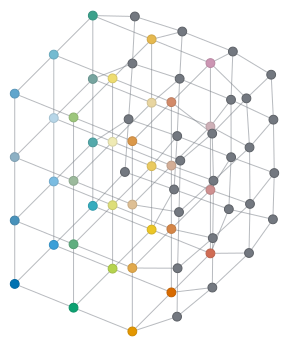

In [17]:
import math


def get_3d_pos(i, j, k, a=22, b=45, p=0.2):
    return (
        +i * math.cos(math.pi * a / 180)
        + j * math.cos(math.pi * b / 180) / 2**p,
        -i * math.sin(math.pi * a / 180)
        + j * math.sin(math.pi * b / 180) / 2**p
        + k,
    )


pos = {
    f"I{i},{j},{k}": get_3d_pos(i, j, k)
    for i in range(Lx)
    for j in range(Ly)
    for k in range(Lz)
}


tn.draw(fix=pos, color=pos.keys())

If you want to retrieve an automatic positioning, e.g. for repeated use in an animation, you can pass the `get='pos'` option, which simply returns the positions as a dict mapping each `tid` to a 2D coordinate:

In [18]:
pos = tn.draw(get="pos")
pos[0], pos[1], pos[2]

(array([-0.19109442,  0.14235293]),
 array([-0.51736222,  0.1395031 ]),
 array([-0.87142562,  0.12399285]))

## Hyper-edges

Hyper edges (indices which appear on 3 or more tensors) are represented as separate 'nodes' of zero size - since they are equivalent to placing a multi-dimensional COPY-tensor is such locations.

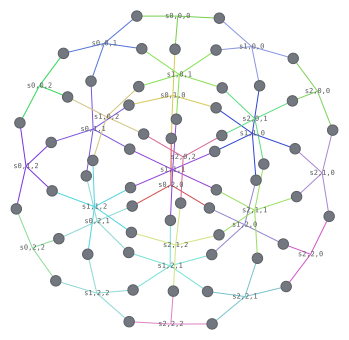

In [19]:
htn = qtn.HTN3D_classical_ising_partition_function(3, 3, 3, beta=0.22)
htn.draw(edge_color=True, show_inds="all")

Another way to visualize such hyperedges, using 'rubber bands', is provided by [`hypernetx`](https://github.com/pnnl/HyperNetX) - both the `ind_map` of a tensor network and the `pos` generate by `draw` are directly compatible:

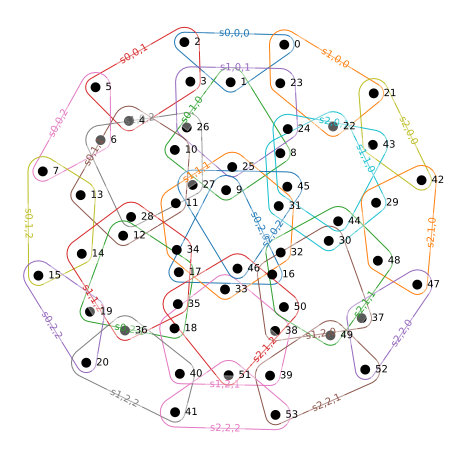

In [20]:
import hypernetx

H = hypernetx.Hypergraph(htn.ind_map)
hypernetx.draw(H, pos=htn.draw(get="pos"))

## Spanning trees

Various algorithms in `quimb` make use of a tree generated by spanning out from a particular region.

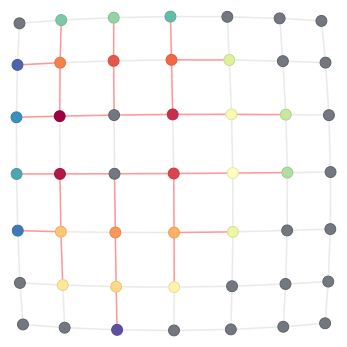

In [21]:
span_opts = {
    "max_distance": 3,
    "distance_sort": "min",
    "ndim_sort": "max",
}

qtn.TN2D_rand(7, 7, 3).draw_tree_span(
    tags=["I2,3", "I2,2"], which="any", **span_opts
)

## Interaction with `matplotlib`

You can either add other stuff to the figure that `quimb` creates, or you can supply a `matplotlib` axis
to add the tensor network drawing to directly. The `adjust_lims` kwarg controls whether the axis limits
should be automatically adjusted to include the whole drawing.

The `return_fig=True` option allows you to modify the figure or save it to file:

Text(0.5, 0.98, 'Yellow World')

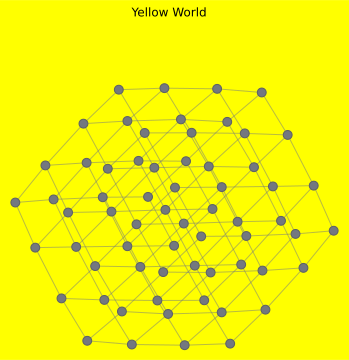

In [22]:
fig = tn.draw(return_fig=True)
fig.patch.set_alpha(1.0)
fig.set_facecolor("yellow")
fig.suptitle("Yellow World")

This could be saved with e.g.:

```python
fig.savefig('my-tn-drawing.png', bbox_inches='tight', dpi=300)
```

The `ax=ax` option allows you to add to an existing plot:

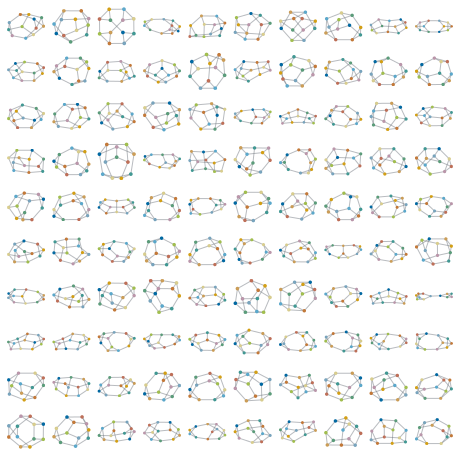

In [23]:
fig, axs = plt.subplots(10, 10, figsize=(8, 8))

for ax in axs.flat:
    tn = qtn.TN_rand_reg(n=12, reg=3, D=2)
    tn.draw(tn.tags, ax=ax, legend=False, show_tags=False)
    ax.axis("off")

## 3D plotting and other backends

A subset of the drawing functionality is supported for plotting backends other than the default `'matplotlib'`
(which uses [quimb.schematic.Drawing](quimb.schematic.Drawing) under the hood). The other backends are:

- `backend="matplotlib3d"` (shorthand `tn.draw_3d()`) plotting a TN in 3D can be useful for debugging the geometry. If run in a script or with the
appropriate notebook backend, the 3D matplotlib plot can be rotated and zoomed etc.

Plotting with the 2D or 3D plotly backend is mostly useful for allowing zooming and panning/rotating, as well as tooltips showing tags, indices and dimensions etc.:

- `backend="plotly"` (shorthand `tn.draw_interactive()`)
- `backend="plotly, dim=3"` (shorthand `tn.draw_3d_interactive()`)

## 'Publication style' figures

There are some likely settings to tweak to generate neat 'publication style'
figures, but probably the most noticeable setting is explicitly laying out
the nodes with `fix`.

Here we demonstrate drawing a PEPS with various options, in particular,
embedding it in a 3D space so no edges are overlapping.

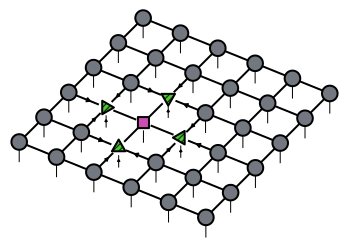

In [24]:
psi = qtn.PEPS.rand(6, 6, 4)

# fix the site tensors in one plane
fix = {psi.site_tag(i, j): get_3d_pos(i, j, 1) for i, j in psi.gen_site_coos()}
# fix the site inidices in plane below
fix.update(
    {psi.site_ind(i, j): get_3d_pos(i, j, 0.5) for i, j in psi.gen_site_coos()}
)

# specific a tensor and its neighbors
tag0 = "I2,2"
tags = ["I2,1", "I1,2", "I2,3", "I3,2"]

# create some arrows
psi.canonize_around_(tag0, max_distance=1)

# draw, with some manual style settings
psi.draw(
    color=(tag0, *tags),
    custom_colors=[(0.8, 0.3, 0.7)] + [(0.3, 0.8, 0.2)] * 4,
    fix=fix,
    edge_color="black",
    edge_alpha=1.0,
    edge_scale=1.0,
    arrow_opts={
        "center": 0.6,
        "linewidth": 2,
        "length": 0.15,
    },
    node_scale=1.5,
    node_outline_darkness=0.0,
    node_outline_size=1.5,
    node_hatch={tag: "////" for tag in tags},
    node_shape={
        tag0: "s",
        "I2,1": "^",
        "I1,2": ">",
        "I2,3": "v",
        "I3,2": "<",
    },
    legend=False,
)

If you want to manually specify all elements and positions, without any reference to an actual `TensorNetwork` object,
and with support for pseudo-3D plotting, then check out the [quimb.schematic.Drawing](quimb.schematic.Drawing)
functionality, with examples here - {ref}`schematic`.